In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
import warnings

warnings.filterwarnings('ignore')

In [6]:
data=pd.read_csv("data/cs-training.csv")
data=data.iloc[:,1:] #去掉第一列无用序号
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

由data.info()可以看出，月收入存在近20%的缺失值，需要进行补充。
亲属数量的缺失值则较少，后续选择直接删除。

各个数据之间的关系

| Variable Name                        | Description                                                  |
| ------------------------------------ | ------------------------------------------------------------ |
| SeriousDlqin2yrs                     | 两年内超过90天或更糟的逾期拖欠（是/否）                                    |
| RevolvingUtilizationOfUnsecuredLines | 贷款及信用卡可用额度与总额度比例                             |
| age                                  | 借款人当时的年龄                                             |
| NumberOfTime30-59DaysPastDueNotWorse | 30-59天逾期但不糟糕次数                                      |
| DebtRatio                            | 负债比率                                                     |
| MonthlyIncome                        | 月收入                                                       |
| NumberOfOpenCreditLinesAndLoans      | 开放式信贷和贷款数量，开放式贷款（分期付款如汽车贷款或抵押贷款）和信贷（如信用卡）的数量 |
| NumberOfTimes90DaysLate              | 90天逾期次数                                                 |
| NumberRealEstateLoansOrLines         | 不动产贷款或额度数量：抵押贷款和不动产放款包括房屋净值信贷额度 |
| NumberOfTime60-89DaysPastDueNotWorse | 60-89天逾期但不糟糕次数：借款人在过去两年内有60-89天逾期还款但不糟糕的次数 |
| NumberOfDependents                   | 不包括本人在内的家属数量                                     |

共有11个特征共以下几类：
1. 逾期相关特征：逾期超过一个月次数，逾期超过两个月次数，逾期超过三个月次数，是否属于严重逾期
2. 个人特征：年龄，月收入，家属数量
3. 个人贷款信息： 贷款可用额度和总额度比例，负债比率，开放贷款数量，不动产额度数量

通过data.info可以看出，月收入和家属数量存在缺失值。
月收入缺失值较多且特征较为重要，选择随机森林算法进行缺失值填充。
家属数量缺失值较少，选择直接删除。

同时，需要注意到，在部分特征中，空值存在意义，不可以被删除或修改。

训练集数据中，好客户数量为：139974,坏客户数量为：10026,坏客户所占比例为：6.68%


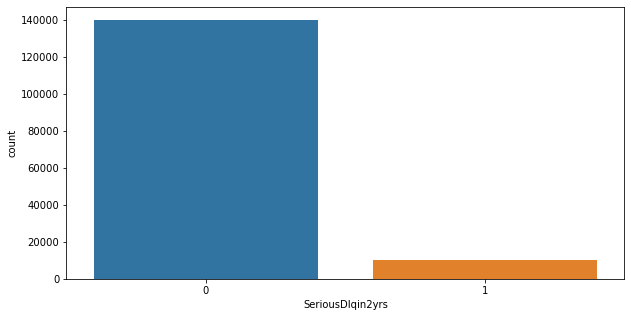

In [7]:
# 异常值处理
# 查看好坏样本客户分布

f,x = plt.subplots(figsize=(10,5))
sns.countplot('SeriousDlqin2yrs',data=data)
plt.show

badnum = data['SeriousDlqin2yrs'].sum()
totalnum = data['SeriousDlqin2yrs'].count()
goodnum = totalnum-badnum
print('训练集数据中，好客户数量为：%i,坏客户数量为：%i,坏客户所占比例为：%.2f%%'%(goodnum,badnum,(badnum/totalnum)*100))

上述代码运行结果为;训练集数据中，好客户数量为：139974,坏客户数量为：10026,坏客户所占比例为：6.68%

可以看出好坏样本差距较大，样本分布不均衡，建模时需要进行处理

count    150000.000000
mean          6.048438
std         249.755371
min           0.000000
25%           0.029867
50%           0.154181
75%           0.559046
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64


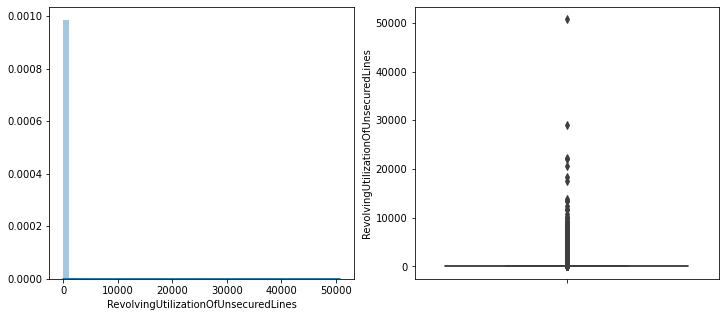

In [15]:
# 可用额度比值特征分布
f,[ax1,ax2]=plt.subplots(1,2,figsize=(12,5))
sns.distplot(data['RevolvingUtilizationOfUnsecuredLines'],ax=ax1)
sns.boxplot(y='RevolvingUtilizationOfUnsecuredLines',data=data,ax=ax2)
plt.show
print(data['RevolvingUtilizationOfUnsecuredLines'].describe(include='all'))

RevolvingUtilizationOfUnsecuredLines

该特征表示可用额度与总额度的比值，比值应该要小于1，通过describe可以看出大部分数据都是小于1的，所以大于1的数据要剔除。

通过图2可以看出50000左右的数据较少，异常值主要分布在1-20000之间。

count    150000.000000
mean         52.295207
std          14.771866
min           0.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         109.000000
Name: age, dtype: float64
训练集数据中，年龄小于18岁的数据为：1
训练集数据中，年龄大于99岁的数据为：13


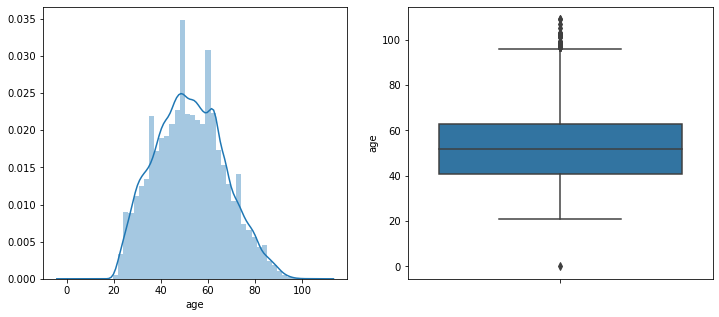

In [31]:
# 年龄分布
f,[ax1,ax2]=plt.subplots(1,2,figsize=(12,5))
sns.distplot(data['age'],ax=ax1)
sns.boxplot(y='age',data=data,ax=ax2)
plt.show
print(data['age'].describe(include='all'))
print('训练集数据中，年龄小于18岁的数据为：%i'%(data[data['age']<18]['age'].count()))
print('训练集数据中，年龄大于99岁的数据为：%i'%(data[data['age']>99]['age'].count()))

年龄小于18岁的数据有且仅有一条且为0，可以作为异常数据删除。

年龄大于100岁的数据存在13条且存在连续性，可以保留。

count    150000.000000
mean          0.421033
std           4.192781
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          98.000000
Name: NumberOfTime30-59DaysPastDueNotWorse, dtype: float64
count    150000.000000
mean          0.240387
std           4.155179
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          98.000000
Name: NumberOfTime60-89DaysPastDueNotWorse, dtype: float64
count    150000.000000
mean          0.265973
std           4.169304
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          98.000000
Name: NumberOfTimes90DaysLate, dtype: float64
<bound method Series.count of 1733      98
2286      98
3884      98
4417      98
4705      98
          ..
147774    98
149153    98
149239    98
149439    98
149769    98
Name: NumberOfTime30-59DaysPastDueNotWorse, Length: 269, dtype: int64>
<bound method Series.count of 1733      

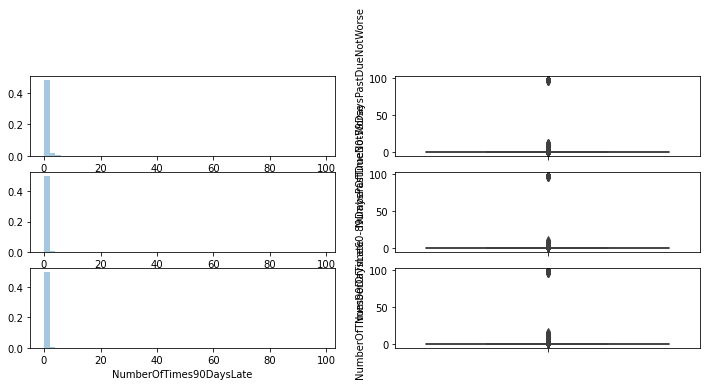

In [38]:
# 逾期30-59天,69-89天，超过90天的次数
f,[[ax1,ax2],[ax3,ax4],[ax5,ax6]]=plt.subplots(3,2,figsize=(12,5))
sns.distplot(data['NumberOfTime30-59DaysPastDueNotWorse'],ax=ax1)
sns.boxplot(y='NumberOfTime30-59DaysPastDueNotWorse',data=data,ax=ax2)
sns.distplot(data['NumberOfTime60-89DaysPastDueNotWorse'],ax=ax3)
sns.boxplot(y='NumberOfTime60-89DaysPastDueNotWorse',data=data,ax=ax4)
sns.distplot(data['NumberOfTimes90DaysLate'],ax=ax5)
sns.boxplot(y='NumberOfTimes90DaysLate',data=data,ax=ax6)

plt.show
print(data['NumberOfTime30-59DaysPastDueNotWorse'].describe(include='all'))
print(data['NumberOfTime60-89DaysPastDueNotWorse'].describe(include='all'))
print(data['NumberOfTimes90DaysLate'].describe(include='all'))


In [42]:
print(data[data['NumberOfTime30-59DaysPastDueNotWorse']>80]['NumberOfTime30-59DaysPastDueNotWorse'])
print(data[data['NumberOfTime60-89DaysPastDueNotWorse']>80]['NumberOfTime60-89DaysPastDueNotWorse'])
print(data[data['NumberOfTimes90DaysLate']>80]['NumberOfTimes90DaysLate'])


print(data[data['NumberOfTime30-59DaysPastDueNotWorse']==98]['NumberOfTime30-59DaysPastDueNotWorse'].count())
print(data[data['NumberOfTime60-89DaysPastDueNotWorse']==98]['NumberOfTime60-89DaysPastDueNotWorse'].count())
print(data[data['NumberOfTimes90DaysLate']==98]['NumberOfTimes90DaysLate'].count())

1733      98
2286      98
3884      98
4417      98
4705      98
          ..
147774    98
149153    98
149239    98
149439    98
149769    98
Name: NumberOfTime30-59DaysPastDueNotWorse, Length: 269, dtype: int64
1733      98
2286      98
3884      98
4417      98
4705      98
          ..
147774    98
149153    98
149239    98
149439    98
149769    98
Name: NumberOfTime60-89DaysPastDueNotWorse, Length: 269, dtype: int64
1733      98
2286      98
3884      98
4417      98
4705      98
          ..
147774    98
149153    98
149239    98
149439    98
149769    98
Name: NumberOfTimes90DaysLate, Length: 269, dtype: int64
264
264
264


可以看出所有逾期数据中，超过80的数据几乎全部为98，可以理解为异常数据进行删除。

count    150000.000000
mean        353.005076
std        2037.818523
min           0.000000
25%           0.175074
50%           0.366508
75%           0.868254
max      329664.000000
Name: DebtRatio, dtype: float64


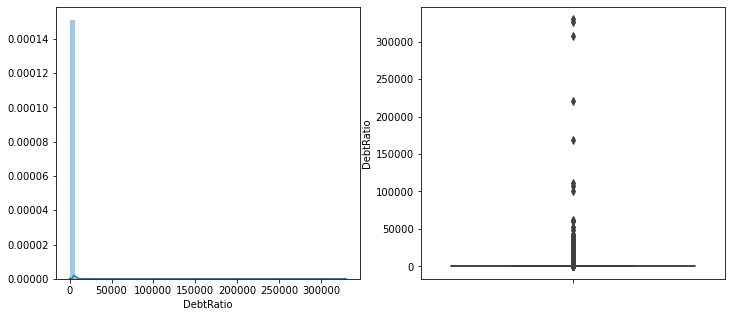

In [43]:
# 负债率
f,[ax1,ax2]=plt.subplots(1,2,figsize=(12,5))
sns.distplot(data['DebtRatio'],ax=ax1)
sns.boxplot(y='DebtRatio',data=data,ax=ax2)
plt.show
print(data['DebtRatio'].describe(include='all'))


考虑到负债率的业务含义，负债率是可以大于1的，所以不认为存在明显异常数据。

count    1.202690e+05
mean     6.670221e+03
std      1.438467e+04
min      0.000000e+00
25%      3.400000e+03
50%      5.400000e+03
75%      8.249000e+03
max      3.008750e+06
Name: MonthlyIncome, dtype: float64


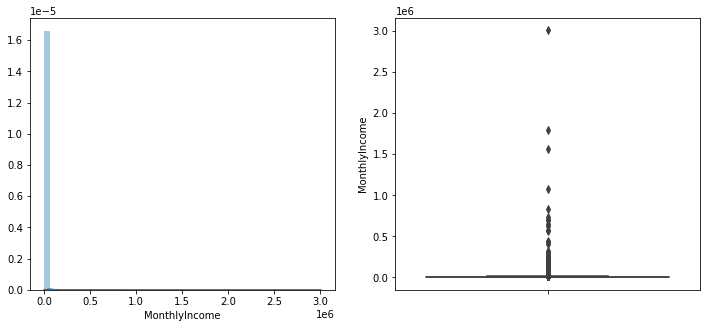

In [45]:
# 月收入
f,[ax1,ax2]=plt.subplots(1,2,figsize=(12,5))
sns.distplot(data['MonthlyIncome'],ax=ax1)
sns.boxplot(y='MonthlyIncome',data=data,ax=ax2)
plt.show
print(data['MonthlyIncome'].describe(include='all'))

月收入由前述分析可以看出存在较多缺失值需要补充。
值的分布不认为存在明显异常。

count    150000.000000
mean          8.452760
std           5.145951
min           0.000000
25%           5.000000
50%           8.000000
75%          11.000000
max          58.000000
Name: NumberOfOpenCreditLinesAndLoans, dtype: float64


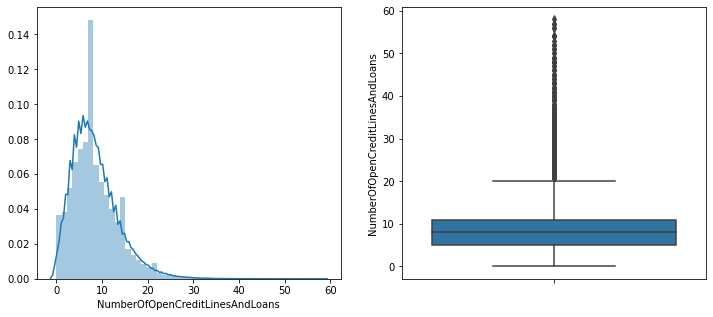

In [46]:
# 信贷数量
f,[ax1,ax2]=plt.subplots(1,2,figsize=(12,5))
sns.distplot(data['NumberOfOpenCreditLinesAndLoans'],ax=ax1)
sns.boxplot(y='NumberOfOpenCreditLinesAndLoans',data=data,ax=ax2)
plt.show
print(data['NumberOfOpenCreditLinesAndLoans'].describe(include='all'))

考虑到信贷数量的业务含义及箱型图上界的值连续，所以不认为存在明显异常。

count    150000.000000
mean          1.018240
std           1.129771
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max          54.000000
Name: NumberRealEstateLoansOrLines, dtype: float64


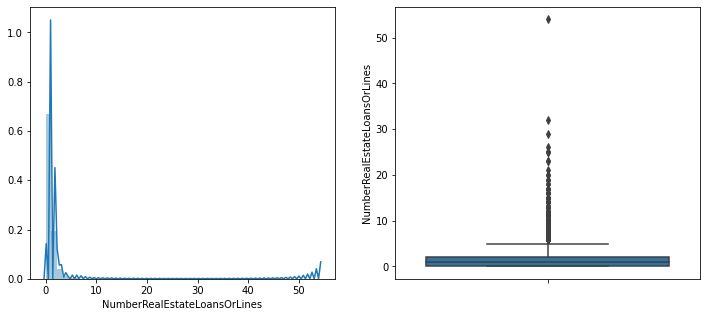

In [47]:
# 不动产数量
f,[ax1,ax2]=plt.subplots(1,2,figsize=(12,5))
sns.distplot(data['NumberRealEstateLoansOrLines'],ax=ax1)
sns.boxplot(y='NumberRealEstateLoansOrLines',data=data,ax=ax2)
plt.show
print(data['NumberRealEstateLoansOrLines'].describe(include='all'))

根据不动产的业务含义，不认为超过40的为异常数据。

count    146076.000000
mean          0.757222
std           1.115086
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          20.000000
Name: NumberOfDependents, dtype: float64


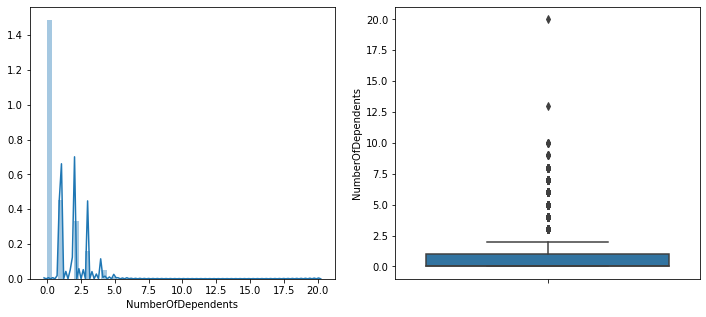

In [48]:
# 家属数量
f,[ax1,ax2]=plt.subplots(1,2,figsize=(12,5))
sns.distplot(data['NumberOfDependents'],ax=ax1)
sns.boxplot(y='NumberOfDependents',data=data,ax=ax2)
plt.show
print(data['NumberOfDependents'].describe(include='all'))


考虑需要剔除家属数量大于15的点，但是目前没有证据显示家属数量不可以大于15。

根据100劳动人口的家属数量，一般为100-150，人均不超过2。